In [4]:
import os
import numpy as np
from PIL import Image

def load_images(folder):
    imgs = []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        img = Image.open(path).convert("L")
        imgs.append(np.array(img, dtype=np.float32))
    return imgs

def extract_blocks(img, block=8):
    H, W = img.shape
    blocks = []
    for i in range(0, H, block):
        for j in range(0, W, block):
            b = img[i:i+block, j:j+block]
            if b.shape == (block, block):
                blocks.append(b.reshape(-1))
    return np.array(blocks)

train_imgs = load_images("TrainSet/")
test_imgs  = load_images("TestSet/")

train_blocks = np.concatenate([extract_blocks(i) for i in train_imgs]) / 255.0
test_blocks  = np.concatenate([extract_blocks(i) for i in test_imgs]) / 255.0


In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)


In [6]:
class MLP_Autoencoder:
    def __init__(self, input_dim=64, hidden_dim=16):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, input_dim) * 0.01
        self.b2 = np.zeros((1, input_dim))

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, X, lr=0.01):
        m = X.shape[0]

        dz2 = (self.a2 - X) * sigmoid_deriv(self.z2)
        dW2 = self.a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.W2.T) * relu_deriv(self.z1)
        dW1 = X.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1


In [7]:
def MSE(X, Y):
    return np.mean((X - Y)**2)

def PSNR(mse):
    return 10 * np.log10(1 / mse)


In [8]:
def train(model, X_train, X_test, epochs=50, lr=0.01):
    train_mse = []
    test_psnr = []

    for ep in range(epochs):
        out = model.forward(X_train)
        loss = MSE(out, X_train)
        train_mse.append(loss)

        model.backward(X_train, lr)

        out_test = model.forward(X_test)
        mse_test = MSE(out_test, X_test)
        test_psnr.append(PSNR(mse_test))

        print(f"Epoch {ep+1} | MSE={loss:.5f} | PSNR={test_psnr[-1]:.2f}")

    return train_mse, test_psnr


In [9]:
results = {}

for hid in [4, 16, 32]:
    print(f"\nTraining with hidden={hid}")
    model = MLP_Autoencoder(input_dim=64, hidden_dim=hid)
    train_curve, test_curve = train(model, train_blocks, test_blocks, epochs=50, lr=0.01)
    results[hid] = (train_curve, test_curve)



Training with hidden=4
Epoch 1 | MSE=0.09459 | PSNR=13.43
Epoch 2 | MSE=0.09458 | PSNR=13.43
Epoch 3 | MSE=0.09458 | PSNR=13.43
Epoch 4 | MSE=0.09458 | PSNR=13.43
Epoch 5 | MSE=0.09458 | PSNR=13.43
Epoch 6 | MSE=0.09457 | PSNR=13.43
Epoch 7 | MSE=0.09457 | PSNR=13.43
Epoch 8 | MSE=0.09457 | PSNR=13.44
Epoch 9 | MSE=0.09456 | PSNR=13.44
Epoch 10 | MSE=0.09456 | PSNR=13.44
Epoch 11 | MSE=0.09456 | PSNR=13.44
Epoch 12 | MSE=0.09455 | PSNR=13.44
Epoch 13 | MSE=0.09455 | PSNR=13.44
Epoch 14 | MSE=0.09455 | PSNR=13.44
Epoch 15 | MSE=0.09454 | PSNR=13.44
Epoch 16 | MSE=0.09454 | PSNR=13.44
Epoch 17 | MSE=0.09454 | PSNR=13.44
Epoch 18 | MSE=0.09453 | PSNR=13.44
Epoch 19 | MSE=0.09453 | PSNR=13.44
Epoch 20 | MSE=0.09453 | PSNR=13.44
Epoch 21 | MSE=0.09453 | PSNR=13.44
Epoch 22 | MSE=0.09452 | PSNR=13.44
Epoch 23 | MSE=0.09452 | PSNR=13.44
Epoch 24 | MSE=0.09452 | PSNR=13.44
Epoch 25 | MSE=0.09451 | PSNR=13.44
Epoch 26 | MSE=0.09451 | PSNR=13.44
Epoch 27 | MSE=0.09451 | PSNR=13.44
Epoch 28 | MS

In [10]:
def reconstruct_image(model, img):
    blocks = extract_blocks(img, block=8) / 255.0
    out = model.forward(blocks) * 255.0
    out = out.astype(np.uint8)

    H, W = img.shape
    new_img = np.zeros((H, W), dtype=np.uint8)

    bi = 0
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            new_img[i:i+8, j:j+8] = out[bi].reshape(8,8)
            bi += 1

    return new_img


In [17]:
import matplotlib.pyplot as plt

def show_reconstruction(model, img):
    blocks = extract_blocks(img, block=8) / 255.0
    out = model.forward(blocks) * 255.0
    out = out.astype(np.uint8)

    H, W = img.shape
    rec = np.zeros((H, W), dtype=np.uint8)

    k = 0
    for i in range(0, H, 8):
        for j in range(0, W, 8):
            rec[i:i+8, j:j+8] = out[k].reshape(8,8)
            k += 1

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')
    plt.axis(False)

    plt.subplot(1,2,2)
    plt.title("Reconstructed")
    plt.imshow(rec, cmap='gray')
    plt.axis(False)

    plt.show()

    return rec


In [12]:
def plot_curves(results):
    plt.figure(figsize=(12,5))

    # Train MSE
    plt.subplot(1,2,1)
    for k in results:
        plt.plot(results[k][0], label=f"hidden={k}")
    plt.title("Train MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # Test PSNR
    plt.subplot(1,2,2)
    for k in results:
        plt.plot(results[k][1], label=f"hidden={k}")
    plt.title("Test PSNR")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    plt.show()


In [13]:
def train_with_visual(model, X_train, img_sample, epochs=20, lr=0.01):
    frames = []

    for ep in range(epochs):
        out = model.forward(X_train)
        model.backward(X_train, lr)

        # reconstruct one sample image each epoch
        rec = reconstruct_image(model, img_sample)
        frames.append(rec)

        print(f"Epoch {ep+1}/{epochs}")

    return frames


In [14]:
def show_frames(frames):
    for i, frame in enumerate(frames):
        plt.imshow(frame, cmap='gray')
        plt.title(f"Epoch {i+1}")
        plt.axis(False)
        plt.show()


In [ ]:
class MLP_Autoencoder_Improved:
    def __init__(self, input_dim=64, hidden_dim=16):
        
        # Preventing vanishing gradients
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2/input_dim)
        self.b1 = np.zeros((1, hidden_dim))

        self.W2 = np.random.randn(hidden_dim, input_dim) * np.sqrt(2/hidden_dim)
        self.b2 = np.zeros((1, input_dim))

        # Momentum states
        self.vW1 = np.zeros_like(self.W1)
        self.vb1 = np.zeros_like(self.b1)
        self.vW2 = np.zeros_like(self.W2)
        self.vb2 = np.zeros_like(self.b2)
        
        self.beta = 0.9  # Momentum factor

    def forward(self, X):
        self.X = X
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def backward(self, lr=0.05):
        m = self.X.shape[0]

        dz2 = (self.a2 - self.X) * sigmoid_deriv(self.z2)
        dW2 = self.a1.T @ dz2 / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.W2.T) * relu_deriv(self.z1)
        dW1 = self.X.T @ dz1 / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Momentum Updates
        self.vW2 = self.beta*self.vW2 + (1-self.beta)*dW2
        self.vb2 = self.beta*self.vb2 + (1-self.beta)*db2
        self.vW1 = self.beta*self.vW1 + (1-self.beta)*dW1
        self.vb1 = self.beta*self.vb1 + (1-self.beta)*db1

        self.W2 -= lr * self.vW2
        self.b2 -= lr * self.vb2
        self.W1 -= lr * self.vW1
        self.b1 -= lr * self.vb1


In [16]:
def train_improved(model, X_train, X_test, epochs=100, lr=0.05):
    train_losses = []
    test_psnr = []

    for ep in range(epochs):
        out = model.forward(X_train)
        loss = MSE(out, X_train)
        train_losses.append(loss)

        model.backward(lr)

        out_test = model.forward(X_test)
        mse_test = MSE(out_test, X_test)
        test_psnr.append(PSNR(mse_test))

        print(f"Epoch {ep+1}/{epochs} | MSE={loss:.6f} | PSNR={test_psnr[-1]:.2f} dB")

    return train_losses, test_psnr


In [18]:
def train_with_frames(model, X_train, img_sample, epochs=20, lr=0.05):
    frames = []

    for ep in range(epochs):
        model.forward(X_train)
        model.backward(lr)

        rec = show_reconstruction(model, img_sample)
        frames.append(rec)

    return frames


In [20]:
# ===============================
# Training Function
# ===============================

def train_autoencoder(model, X_train, X_test, epochs=50, lr=0.05):
    train_losses = []
    test_psnr = []

    for ep in range(epochs):
        out = model.forward(X_train)
        loss = MSE(out, X_train)
        train_losses.append(loss)

        model.backward(lr)

        out_test = model.forward(X_test)
        mse_test = MSE(out_test, X_test)
        test_psnr.append(PSNR(mse_test))

        print(f"Epoch {ep+1}/{epochs} | MSE={loss:.6f} | PSNR={test_psnr[-1]:.2f} dB")

    return train_losses, test_psnr


Epoch 1/80 | MSE=0.103122 | PSNR=12.86 dB
Epoch 2/80 | MSE=0.102645 | PSNR=12.92 dB
Epoch 3/80 | MSE=0.101784 | PSNR=13.00 dB
Epoch 4/80 | MSE=0.100657 | PSNR=13.09 dB
Epoch 5/80 | MSE=0.099407 | PSNR=13.18 dB
Epoch 6/80 | MSE=0.098155 | PSNR=13.26 dB
Epoch 7/80 | MSE=0.097011 | PSNR=13.33 dB
Epoch 8/80 | MSE=0.096057 | PSNR=13.37 dB
Epoch 9/80 | MSE=0.095344 | PSNR=13.40 dB
Epoch 10/80 | MSE=0.094893 | PSNR=13.41 dB
Epoch 11/80 | MSE=0.094754 | PSNR=13.42 dB
Epoch 12/80 | MSE=0.094686 | PSNR=13.42 dB
Epoch 13/80 | MSE=0.094656 | PSNR=13.42 dB
Epoch 14/80 | MSE=0.094623 | PSNR=13.43 dB
Epoch 15/80 | MSE=0.094577 | PSNR=13.43 dB
Epoch 16/80 | MSE=0.094534 | PSNR=13.43 dB
Epoch 17/80 | MSE=0.094494 | PSNR=13.43 dB
Epoch 18/80 | MSE=0.094457 | PSNR=13.43 dB
Epoch 19/80 | MSE=0.094422 | PSNR=13.43 dB
Epoch 20/80 | MSE=0.094388 | PSNR=13.44 dB
Epoch 21/80 | MSE=0.094355 | PSNR=13.44 dB
Epoch 22/80 | MSE=0.094322 | PSNR=13.44 dB
Epoch 23/80 | MSE=0.094290 | PSNR=13.44 dB
Epoch 24/80 | MSE=0.

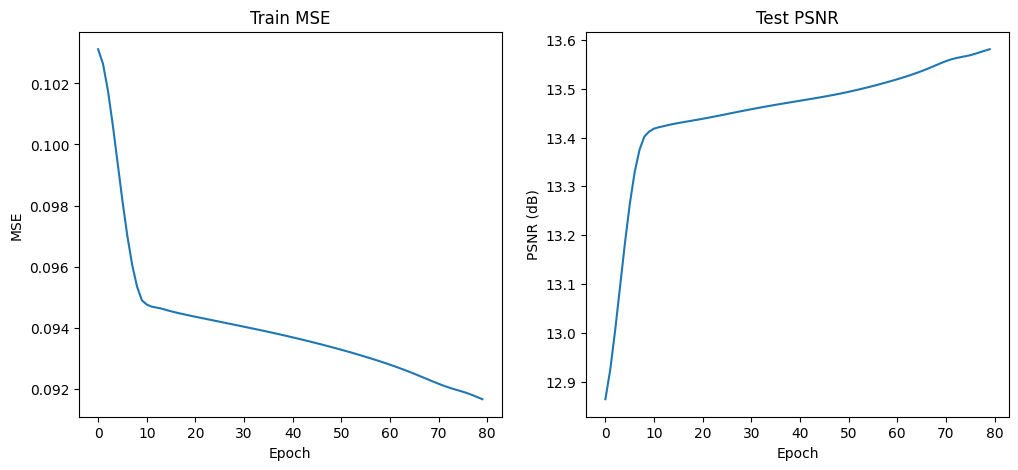

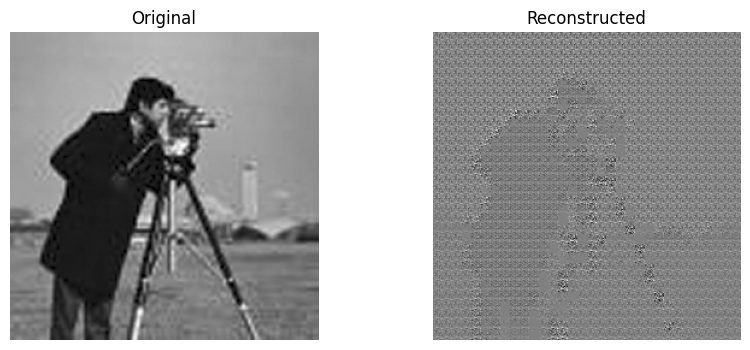

In [21]:
train_images = load_images("TrainSet")
test_images  = load_images("TestSet")

train_blocks = np.concatenate([extract_blocks(img) for img in train_images]) / 255.0
test_blocks  = np.concatenate([extract_blocks(img) for img in test_images])  / 255.0


# ===============================
# Train Model
# ===============================

model = MLP_Autoencoder_Improved(input_dim=64, hidden_dim=16)

train_curve, test_curve = train_autoencoder(
    model,
    train_blocks,
    test_blocks,
    epochs=80,
    lr=0.05
)


# ===============================
# Plot Curves
# ===============================

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_curve)
plt.title("Train MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(test_curve)
plt.title("Test PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.show()


# ===============================
# Show Reconstruction on a Test Image
# ===============================

example_img = test_images[0]
reconstructed = reconstruct_image(model, example_img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(example_img, cmap='gray')
plt.axis(False)

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(reconstructed, cmap='gray')
plt.axis(False)

plt.show()
